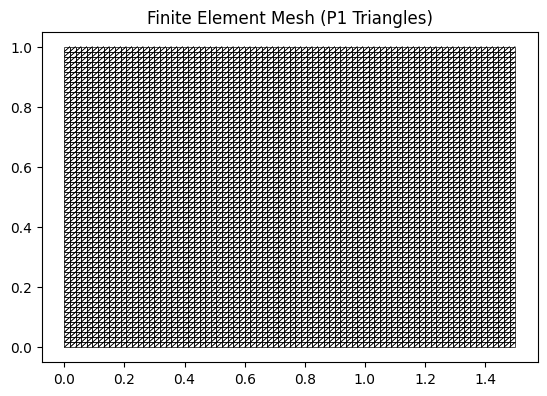

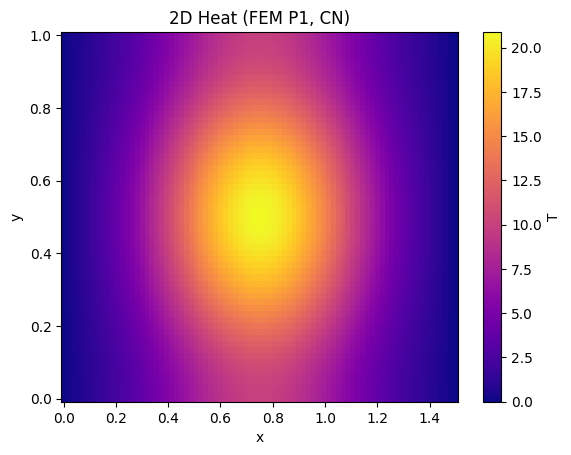

In [2]:
# fem2d_heat.py
# pip install numpy scipy matplotlib

import numpy as np
from scipy.sparse import lil_matrix, csr_matrix, diags
from scipy.sparse.linalg import spsolve

def build_rect_tri_mesh(NX=40, NY=40, Lx=1.0, Ly=1.0):
    """Uniform grid nodes and 2*NX*NY triangles (right-leaning split)."""
    x = np.linspace(0.0, Lx, NX+1)
    y = np.linspace(0.0, Ly, NY+1)
    X, Y = np.meshgrid(x, y)               # shape (NY+1, NX+1)
    coords = np.column_stack([X.ravel(), Y.ravel()])
    def idx(i,j): return j*(NX+1) + i

    tris = []
    for j in range(NY):
        for i in range(NX):
            n0 = idx(i,   j)
            n1 = idx(i+1, j)
            n2 = idx(i,   j+1)
            n3 = idx(i+1, j+1)
            # triangles: (n0,n1,n3) and (n0,n3,n2)
            tris.append([n0,n1,n3])
            tris.append([n0,n3,n2])
    tris = np.asarray(tris, dtype=np.int32)
    return coords, tris, (x, y)

def assemble_K_M(coords, tris, k=1.0, rho=1.0, cp=1.0):
    """Assemble global stiffness K and consistent mass M for P1 triangles."""
    N = coords.shape[0]
    K = lil_matrix((N, N), dtype=float)
    M = lil_matrix((N, N), dtype=float)
    rc = rho*cp

    for (n1, n2, n3) in tris:
        x1,y1 = coords[n1]; x2,y2 = coords[n2]; x3,y3 = coords[n3]
        detJ = (x2-x1)*(y3-y1) - (x3-x1)*(y2-y1)
        A = 0.5*abs(detJ)
        if A <= 1e-18: 
            continue

        # Gradients of shape functions via b,c coefficients
        b = np.array([y2 - y3, y3 - y1, y1 - y2])
        c = np.array([x3 - x2, x1 - x3, x2 - x1])

        Ke = (k/(4.0*A))*(np.outer(b,b) + np.outer(c,c))
        Me = (rc*A/12.0)*np.array([[2,1,1],[1,2,1],[1,1,2]])

        nodes = [n1,n2,n3]
        for a in range(3):
            ia = nodes[a]
            for b_ in range(3):
                ib = nodes[b_]
                K[ia, ib] += Ke[a, b_]
                M[ia, ib] += Me[a, b_]

    return K.tocsr(), M.tocsr()

def assemble_F(coords, tris, q_func, t):
    """Load vector F from volumetric source q(x,y,t), 1-point (centroid) rule."""
    N = coords.shape[0]
    F = np.zeros(N)
    for (n1, n2, n3) in tris:
        x1,y1 = coords[n1]; x2,y2 = coords[n2]; x3,y3 = coords[n3]
        detJ = (x2-x1)*(y3-y1) - (x3-x1)*(y2-y1)
        A = 0.5*abs(detJ)
        xc = (x1+x2+x3)/3.0; yc=(y1+y2+y3)/3.0
        q = q_func(xc, yc, t)
        fe = (q*A/3.0)  # each node gets q*A/3 for uniform q over the element
        F[n1] += fe; F[n2] += fe; F[n3] += fe
    return F

def impose_dirichlet(A, b, fixed_nodes, fixed_values):
    """
    Enforce Dirichlet by row replacement (A[i,:]=e_i^T, b[i]=Tbc).
    For symmetry, you'd also zero columns and adjust b, but row fix works well in practice.
    """
    A = A.tolil()
    for i, val in zip(fixed_nodes, fixed_values):
        A.rows[i] = [i]
        A.data[i] = [1.0]
        b[i] = val
    return A.tocsr(), b

def plot_mesh(coords, tris, show=True):
    import matplotlib.pyplot as plt
    from matplotlib.collections import LineCollection

    # Extract line segments from triangle connectivity
    segments = []
    for tri in tris:
        for i in range(3):
            a = coords[tri[i]]
            b = coords[tri[(i+1)%3]]
            segments.append([a, b])

    lc = LineCollection(segments, colors="k", linewidths=0.5)
    fig, ax = plt.subplots()
    ax.add_collection(lc)
    ax.autoscale()
    ax.set_aspect("equal")
    ax.set_title("Finite Element Mesh (P1 Triangles)")
    if show:
        plt.show()
    return fig, ax

##################################################
# what it does:
# it builds the mesh (2d plate)
# assembles the FEM matrices (stiffness and mass)
# runs the time-stepping solver (Crank-Nicolson or Backward Euler)
# gives the temperature field at the final time and (optimally) all time snapshots
##################################################
def heat2d_fem(
    NX=60, NY=60, Lx=1.0, Ly=1.0,
    k=1.0, rho=1.0, cp=1.0,
    T_left=0.0, T_right=0.0,
    q_func=lambda x,y,t: 0.0,           # source q(x,y,t)
    dt=1e-3, t_end=0.25,
    scheme="CN",                        # "BE" (Backward Euler) or "CN" (Crank–Nicolson)
    return_history=False, output_every=None,
    plotmesh=False
):
    """
    Returns (x, y, T_final, history)
      - x, y: 1D coordinate arrays (nodes)
      - T_final: (NY+1, NX+1) array at t_end
      - history: list of (t, T_snapshot) if requested
    """
    coords, tris, (x, y) = build_rect_tri_mesh(NX, NY, Lx, Ly)
    if plotmesh == True:
        plot_mesh(coords, tris, show=True)
    N = coords.shape[0]
    npx = NX+1

    # Assemble time-invariant K, M
    K, M = assemble_K_M(coords, tris, k=k, rho=rho, cp=cp)

    # Initial condition: linear between left and right
    T = np.zeros(N)
    T[:] = T_left + (T_right - T_left)*(coords[:,0]/Lx)

    # Dirichlet on left/right boundary node sets
    left_nodes  = np.where(np.isclose(coords[:,0], 0.0))[0]
    right_nodes = np.where(np.isclose(coords[:,0], Lx))[0]
    fixed_nodes = np.concatenate([left_nodes, right_nodes])
    fixed_vals  = np.concatenate([np.full_like(left_nodes,  T_left,  dtype=float),
                                  np.full_like(right_nodes, T_right, dtype=float)])

    # Time-stepping matrices (scheme-dependent, but K and M are constant)
    nsteps = int(np.ceil(t_end/dt))
    history = []

    t = 0.0
    for step in range(1, nsteps+1):
        t_np1 = t + dt

        if scheme.upper() == "CN":
            # Crank–Nicolson: A = M/dt + 0.5K; rhs = (M/dt - 0.5K) T^n + 0.5(F^{n+1}+F^n)
            A = (M/dt + 0.5*K).tocsr()
            F_n   = assemble_F(coords, tris, q_func, t)
            F_np1 = assemble_F(coords, tris, q_func, t_np1)
            rhs = (M/dt - 0.5*K) @ T + 0.5*(F_n + F_np1)
        else:
            # Backward Euler: A = M/dt + K; rhs = (M/dt) T^n + F^{n+1}
            A = (M/dt + K).tocsr()
            F_np1 = assemble_F(coords, tris, q_func, t_np1)
            rhs = (M/dt) @ T + F_np1

        # Impose Dirichlet
        A, rhs = impose_dirichlet(A, rhs, fixed_nodes, fixed_vals)

        # Solve
        T = spsolve(A, rhs)

        # Save snapshots
        if return_history and (output_every is None or step % output_every == 0 or step == nsteps):
            history.append((t_np1, T.reshape(NY+1, NX+1).copy()))

        t = t_np1

    return x, y, T.reshape(NY+1, NX+1), history if return_history else None


if __name__ == "__main__":
    # Example: smooth transient with a decaying Gaussian source near x=0.75,y=0.5; note exponential decay of source wrt time
    def q(x, y, t):
        return 100.0*np.exp(-10*(x-0.75)**2 - 10*(y-0.5)**2) * np.exp(-1*t)

    x, y, T, _ = heat2d_fem(
        NX=80, NY=60, Lx=1.5, Ly=1.0,
        k=0.10, rho=1.0, cp=1.0,
        T_left=0.0, T_right=0.0,
        q_func=q,
        dt=5e-3, t_end=0.5,
        scheme="CN",                    # try "BE" or "CN"
        return_history=False,
        plotmesh=True
    )

    # Quick plot
    try:
        import matplotlib.pyplot as plt
        X, Y = np.meshgrid(x, y)
        plt.figure()
        pc = plt.pcolormesh(X, Y, T, shading="auto", cmap="plasma")
        plt.colorbar(pc, label="T")
        plt.xlabel("x"); plt.ylabel("y"); plt.title("2D Heat (FEM P1, CN)")
        plt.show()
    except Exception as e:
        print("Plotting skipped:", e)

# PART A
If parameters k=0.1,1.0,10.0, t<sub>f</sub> =0.1,0.2,0.5 plot the temperature field T(x,y,t<sub>f</sub>). 
Please sample T(x,y,t) at 10 randomly chosen points and plot T(t) at each site.

In [3]:
# PART A
# If parameters k=0.1,1.0,10.0, t_f =0.1,0.2,0.5 plot the temperature field T(x,y,t_f).

ks = [0.1, 1.0, 10.0]
tfs = [0.1, 0.2, 0.5]
result_dict = {}

# make it so you can view all the figers at one time

for ik, k in enumerate(ks):
    for itf, tf in enumerate(tfs):
        print("k: ", k, " | tf: ", tf)
        x, y, T_final, history = heat2d_fem(NX=80, NY=60, Lx=1.5, Ly=1.0,
                                            k=k, q_func=q, dt=5e-3, t_end=tf,
                                            return_history=True, output_every=10)
        result_dict[(k, tf)] = [x, y, T_final, history]



k:  0.1  | tf:  0.1
k:  0.1  | tf:  0.2
k:  0.1  | tf:  0.5
k:  1.0  | tf:  0.1
k:  1.0  | tf:  0.2
k:  1.0  | tf:  0.5
k:  10.0  | tf:  0.1
k:  10.0  | tf:  0.2
k:  10.0  | tf:  0.5


<class 'numpy.ndarray'>
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


Text(0.5, 0.98, 'Temperature for ks and tfs')

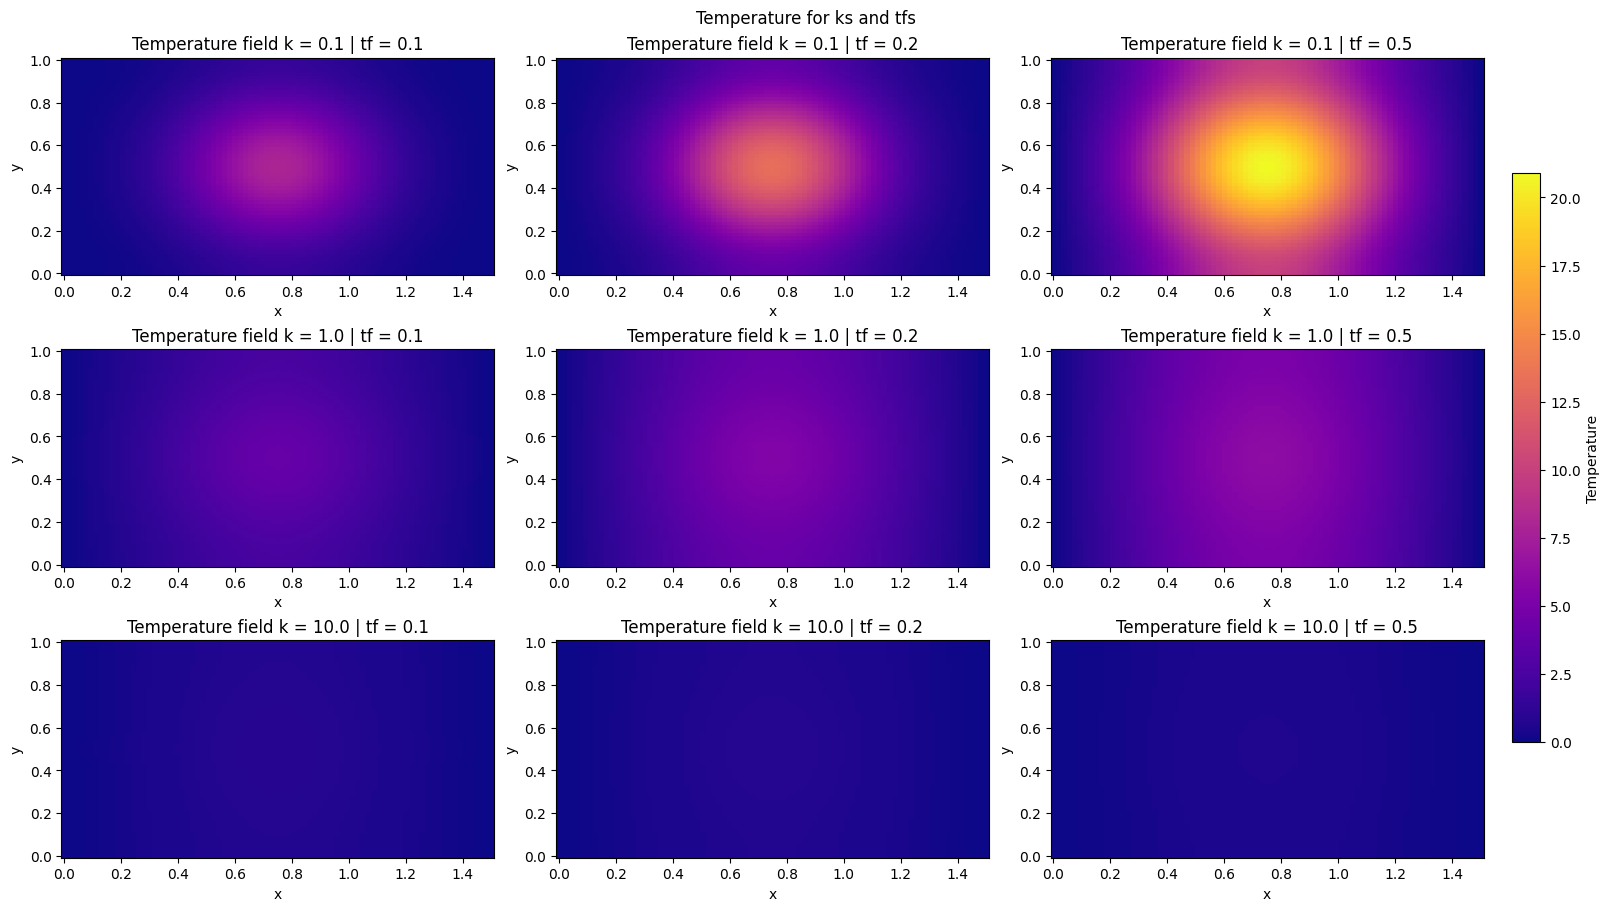

In [4]:
print(type(T_final))
print([type(r[2]) for r in result_dict.values()])
overall_min = min(r[2].min() for r in result_dict.values())
overall_max = max(r[2].max() for r in result_dict.values())

fig, axes = plt.subplots(len(ks), len(tfs), figsize=(16, 9), constrained_layout=True)

for ik, k in enumerate(ks):
    for itf, tf in enumerate(tfs):
        # Quick plot
        ax = axes[ik, itf]
        X, Y = np.meshgrid(x, y)
        pc = ax.pcolormesh(X, Y, result_dict[(k, tf)][2], shading="auto", cmap="plasma", vmax=overall_max, vmin=overall_min)
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_title(f"Temperature field k = {k} | tf = {tf}")

# Add a colorbar and overall title
cbar = fig.colorbar(pc, ax=axes, orientation='vertical', fraction=.02, pad=.02)
cbar.set_label("Temperature")
plt.suptitle("Temperature for ks and tfs")

Text(0.5, 0.98, 'Temperature for ks and tfs')

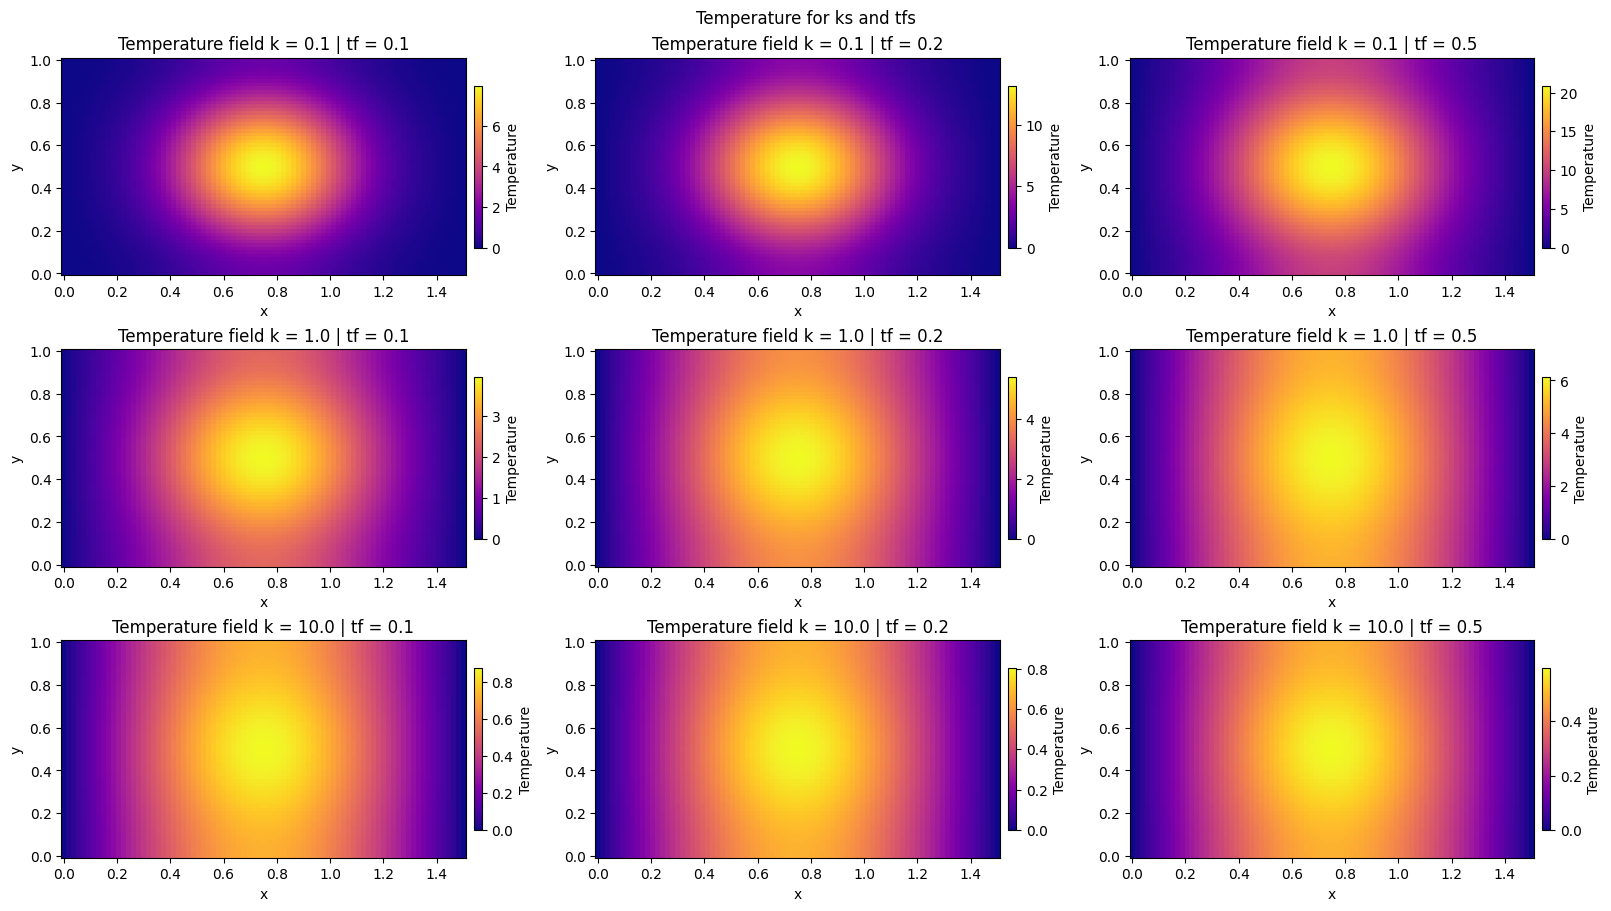

In [5]:
fig, axes = plt.subplots(len(ks), len(tfs), figsize=(16, 9), constrained_layout=True)


for ik, k in enumerate(ks):
    for itf, tf in enumerate(tfs):
        # Quick plot
        ax = axes[ik, itf]
        X, Y = np.meshgrid(x, y)
        pc = ax.pcolormesh(X, Y, result_dict[(k, tf)][2], shading="auto", cmap="plasma")
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_title(f"Temperature field k = {k} | tf = {tf}")

        # Add a colorbar and overall title
        cbar = fig.colorbar(pc, ax=ax, orientation='vertical', fraction=.02, pad=.02)
        cbar.set_label("Temperature")
plt.suptitle("Temperature for ks and tfs")

### What is going on in the temperature field plots?

The yellow gets bigger why?

Because K which is effected by k governs how heat spreads between nodes. So a larger k means faster heat transfer.

It gets bigger when you go across the rows because tf (final time) is getting bigger which means the heat can spread out more since it is a longer period of time.

Selected node coordinates (x, y):
[[0.875 0.55 ]
 [0.1   0.05 ]
 [0.975 0.5  ]
 [0.925 0.2  ]
 [0.4   0.825]
 [0.575 0.85 ]
 [0.825 0.825]
 [0.025 0.8  ]
 [0.725 0.025]
 [0.5   0.675]]
Saved: T_vs_t_k0.1_tf0.1.csv
Saved: T_vs_t_k0.1_tf0.2.csv
Saved: T_vs_t_k0.1_tf0.5.csv
Saved: T_vs_t_k1.0_tf0.1.csv
Saved: T_vs_t_k1.0_tf0.2.csv
Saved: T_vs_t_k1.0_tf0.5.csv
Saved: T_vs_t_k10.0_tf0.1.csv
Saved: T_vs_t_k10.0_tf0.2.csv
Saved: T_vs_t_k10.0_tf0.5.csv


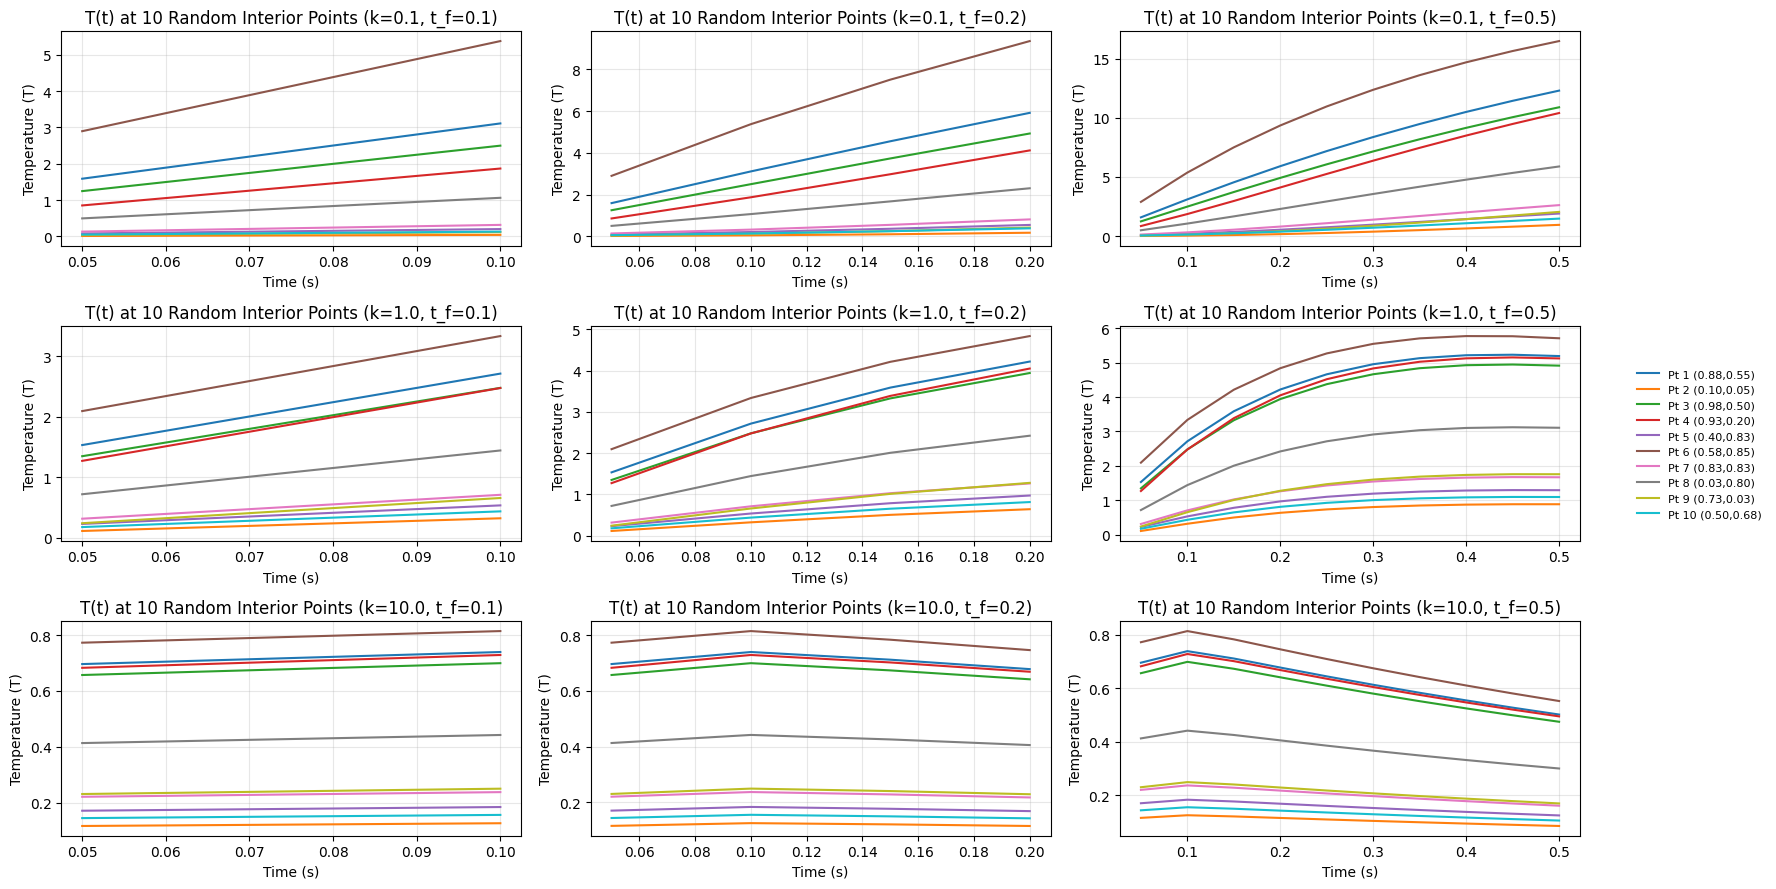

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
# Please sample T(x,y,t) at 10 randomly chosen points and plot T(t) at each site.

# build the mesh
coords, tris, (x, y) = build_rect_tri_mesh(NX=40, NY=40, Lx=1.0, Ly=1.0)

# Identify interior (non-boundary) nodes
tol = 1e-8
boundary = (np.isclose(coords[:,0], 0.0, atol=tol) | 
            np.isclose(coords[:,0], max(x), atol=tol) |
            np.isclose(coords[:,1], 0.0, atol=tol) | 
            np.isclose(coords[:,1], max(y), atol=tol))
interior_nodes = np.where(~boundary)[0]

# Select 10 random interior nodes
np.random.seed(123)  # reproducible
sample_nodes = np.random.choice(interior_nodes, size=10, replace=False)
print("Selected node coordinates (x, y):")
print(coords[sample_nodes])

# subplots laid out for viewing in a nice way
ncols = 3
nplots = len(result_dict)
nrows = int(np.ceil(nplots / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 9), sharex=False, sharey=False)
axes = axes.flatten()

# Loop over all (k, tf) cases from result_dict
for idx, ((k_val, tf_val), (x, y, T_final, history)) in enumerate(result_dict.items()):
    ax = axes[idx]
    times = [t for t, _ in history]
    T_snapshots = [T.flatten() for _, T in history]

    # Extract temperature vs time at selected nodes
    T_time_series = np.array([[T[node] for node in sample_nodes] for T in T_snapshots])

    # Plot T(t)
    for i, node in enumerate(sample_nodes):
        ax.plot(times, T_time_series[:, i], label=f"Pt {i+1} ({coords[node,0]:.2f},{coords[node,1]:.2f})")
                 
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Temperature (T)")
    ax.set_title(f"T(t) at 10 Random Interior Points (k={k_val}, t_f={tf_val})")
    ax.grid(True, alpha=0.3)

    # save data for later regression
    df = pd.DataFrame(T_time_series, columns=[f"Point_{i+1}" for i in range(10)])
    df.insert(0, "time", times)
    filename = f"T_vs_t_k{k_val}_tf{tf_val}.csv"
    df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

fig.legend(
    axes[0].get_lines(),                              # use line handles from first axes
    [line.get_label() for line in axes[0].get_lines()],
    loc="center left", bbox_to_anchor=(1.02, 0.5),
    fontsize=8, frameon=False
)
plt.tight_layout()
plt.show()

# PART B
Please fit regressions with algebraic and trigonometric polynomials
$$
\sum_{m=1}^{5} \sum_{n=1}^{5} a_{mn} \sin\!\left( m \frac{2\pi x}{1.5} \right)
\sin\!\left( n 2\pi y \right) \to T(x, y, t_f)
$$

$$
\sum_{m=1}^{5} \sum_{n=1}^{5} a_{mn} \cos\!\left( m \frac{2\pi x}{1.5} \right)
\cos\!\left( n 2\pi y \right) \to T(x, y, t_f)
$$

$$
\sum_{m=0}^{5} \sum_{n=0}^{5} a_{mn} \sin\!\left( m \frac{2\pi x}{1.5} \right)
\sin\!\left( n 2\pi y \right) \to T(x, y, t_f)
$$

$$
\sum_{m=0}^{5} \sum_{n=0}^{5} a_{mn} \cos\!\left( m \frac{2\pi x}{1.5} \right)
\cos\!\left( n 2\pi y \right) \to T(x, y, t_f)
$$

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import lstsq

def fit_trig_surface(x, y, T, Lx=1.5, Ly=1.0, m_start=1, n_start=1, Mmax=5, Nmax=5, trig='sin', plot=True):
    """
    Fits a double trigonometric regression of the form:
        T(x,y) ≈ Σ_m Σ_n a_mn * trig(m*2πx/Lx) * trig(n*2πy)
    Parameters
    ----------
    x, y : 1D arrays of grid coordinates
    T    : 2D array of FEM temperature field (shape len(y)×len(x))
    Lx, Ly : domain lengths
    m_start, n_start : 0 or 1 (whether to include the zero term)
    Mmax, Nmax : maximum mode numbers in x and y
    trig : 'sin' or 'cos'
    plot : whether to plot original vs fitted fields
    Returns
    -------
    coeffs : 2D array of a_mn coefficients (shape Mmax×Nmax)
    rmse   : root-mean-square error of fit
    T_fit  : fitted 2D array same shape as T
    """
    X, Y = np.meshgrid(x, y)
    Xf, Yf, Tf = X.ravel(), Y.ravel(), T.ravel()

    # Build basis matrix Φ
    basis, labels = [], []
    for m in range(m_start, Mmax + 1):
        for n in range(n_start, Nmax + 1):
            if trig.lower() == 'sin':
                phi = np.sin(m * 2*np.pi*Xf/Lx) * np.sin(n * 2*np.pi*Yf/Ly)
            elif trig.lower() == 'cos':
                phi = np.cos(m * 2*np.pi*Xf/Lx) * np.cos(n * 2*np.pi*Yf/Ly)
            else:
                raise ValueError("trig must be 'sin' or 'cos'")
            basis.append(phi)
            labels.append((m, n))
    Phi = np.column_stack(basis)

    # Least-squares solution for coefficients
    coeffs_vec, *_ = lstsq(Phi, Tf, rcond=None)

    # Reconstruct fitted field
    T_fit = Phi @ coeffs_vec
    T_fit = T_fit.reshape(T.shape)
    rmse = np.sqrt(np.mean((T_fit - T)**2))

    # plot
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        pcm0 = axs[0].pcolormesh(X, Y, T, shading='auto', cmap='plasma')
        axs[0].set_title(f'Original FEM field (k={k_val}, tf={tf_val})')
        plt.colorbar(pcm0, ax=axs[0])
        pcm1 = axs[1].pcolormesh(X, Y, T_fit, shading='auto', cmap='plasma')
        axs[1].set_title(f'{trig} fit, m∈[{m_start},{Mmax}], n∈[{n_start},{Nmax}]\nRMSE={rmse:.3e}')
        plt.colorbar(pcm1, ax=axs[1])
        plt.tight_layout()
        plt.show()

    # Pack coefficients into 2D matrix for easy viewing
    coeffs = np.zeros((Mmax+1, Nmax+1))
    for (m, n), a in zip(labels, coeffs_vec):
        coeffs[m, n] = a

    return coeffs, rmse, T_fit


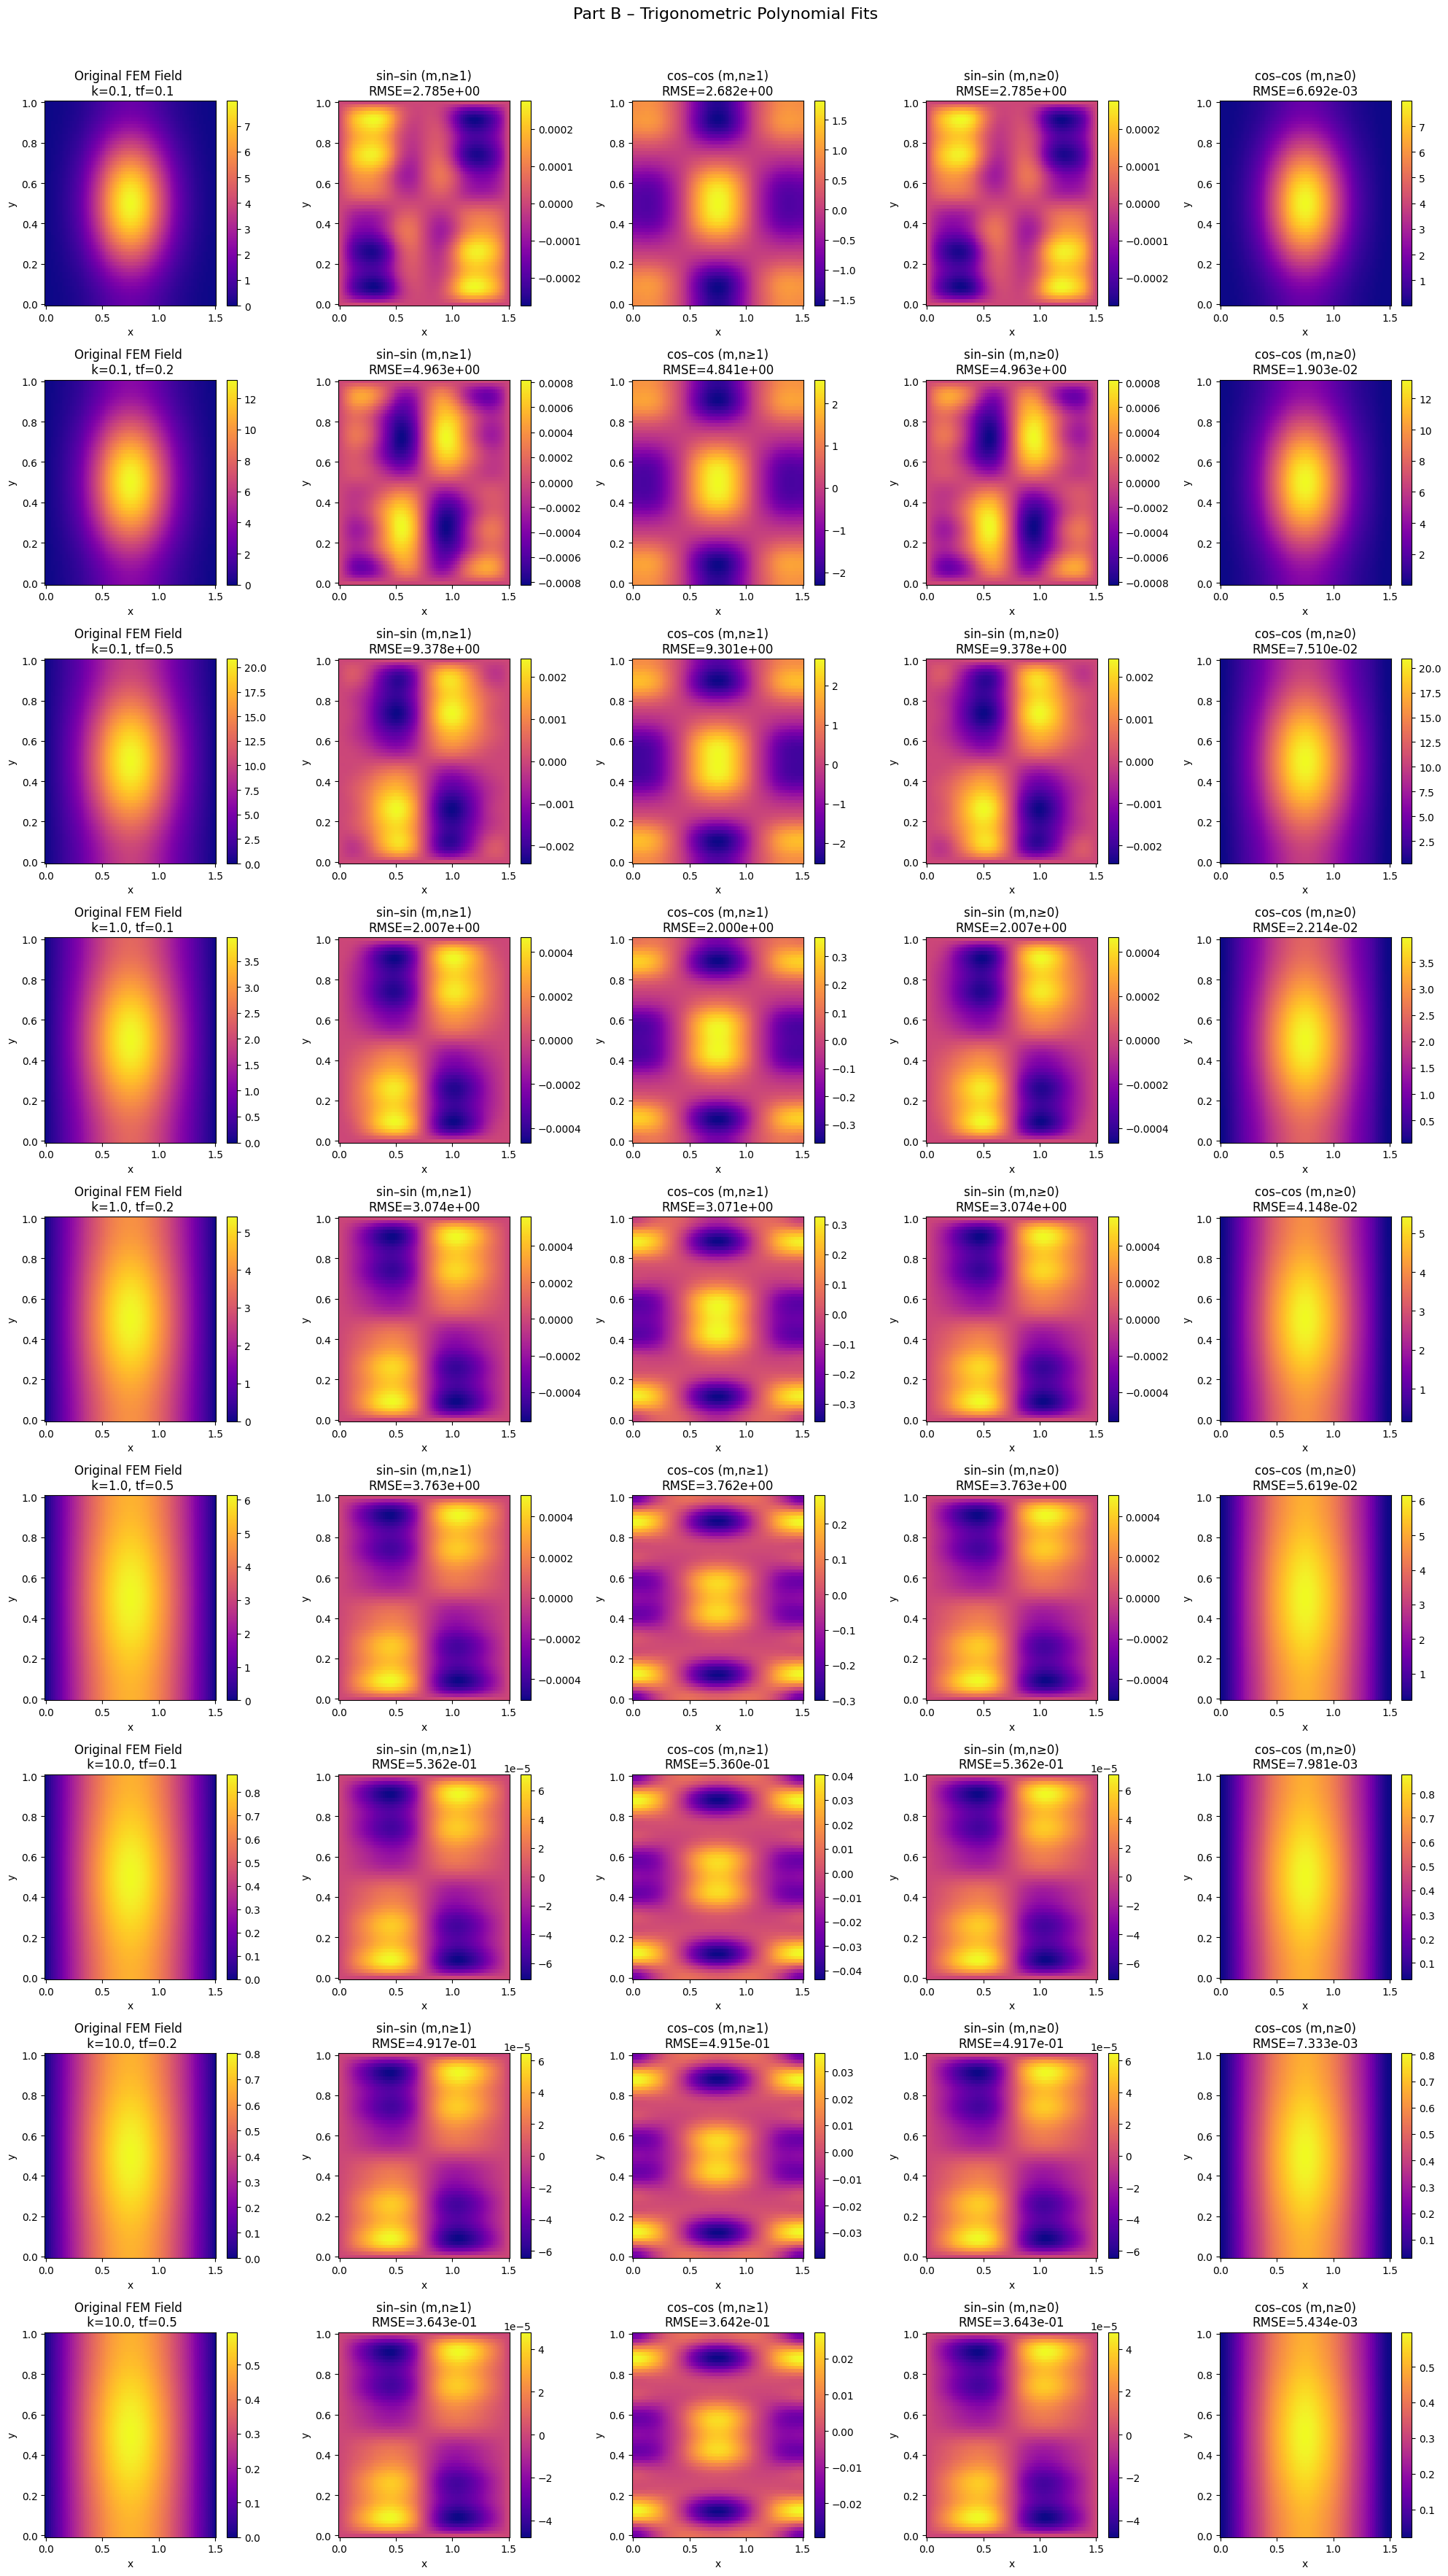

In [ ]:
# each of the four fits for each (k, tf) pair
# and plot original + all four fits in a row
# each on there own scale

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(9, 5, figsize=(20, 36))
fig.suptitle(f"Part B – Trigonometric Polynomial Fits", fontsize=16)

i = 0

for (k_val, tf_val), (x, y, T, _) in result_dict.items():

    # === Run all four fits (no plotting inside the function) ===
    coeffs_sin11, rmse_sin11, Tfit_sin11 = fit_trig_surface(x, y, T, m_start=1, n_start=1, trig='sin', plot=False)
    coeffs_cos11, rmse_cos11, Tfit_cos11 = fit_trig_surface(x, y, T, m_start=1, n_start=1, trig='cos', plot=False)
    coeffs_sin00, rmse_sin00, Tfit_sin00 = fit_trig_surface(x, y, T, m_start=0, n_start=0, trig='sin', plot=False)
    coeffs_cos00, rmse_cos00, Tfit_cos00 = fit_trig_surface(x, y, T, m_start=0, n_start=0, trig='cos', plot=False)

    X, Y = np.meshgrid(x, y)

    # === Row 1: original + fits (top row) ===
    titles_top = [
        f"Original FEM Field \n k={k_val}, tf={tf_val}",
        "sin–sin (m,n≥1)",
        "cos–cos (m,n≥1)",
        "sin–sin (m,n≥0)",
        "cos–cos (m,n≥0)"
    ]
    fields_top = [T, Tfit_sin11, Tfit_cos11, Tfit_sin00, Tfit_cos00]
    rmses = [0, rmse_sin11, rmse_cos11, rmse_sin00, rmse_cos00]

    for j in range(5):
        pcm = axes[i, j].pcolormesh(X, Y, fields_top[j], shading='auto', cmap='plasma')
        axes[i, j].set_title(f"{titles_top[j]}\nRMSE={rmses[j]:.3e}" if j > 0 else titles_top[j])
        fig.colorbar(pcm, ax=axes[i, j])
        axes[i, j].set_xlabel("x"); axes[i, j].set_ylabel("y")
    
    i += 1

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Using global color scale: vmin=-2.529, vmax=20.926


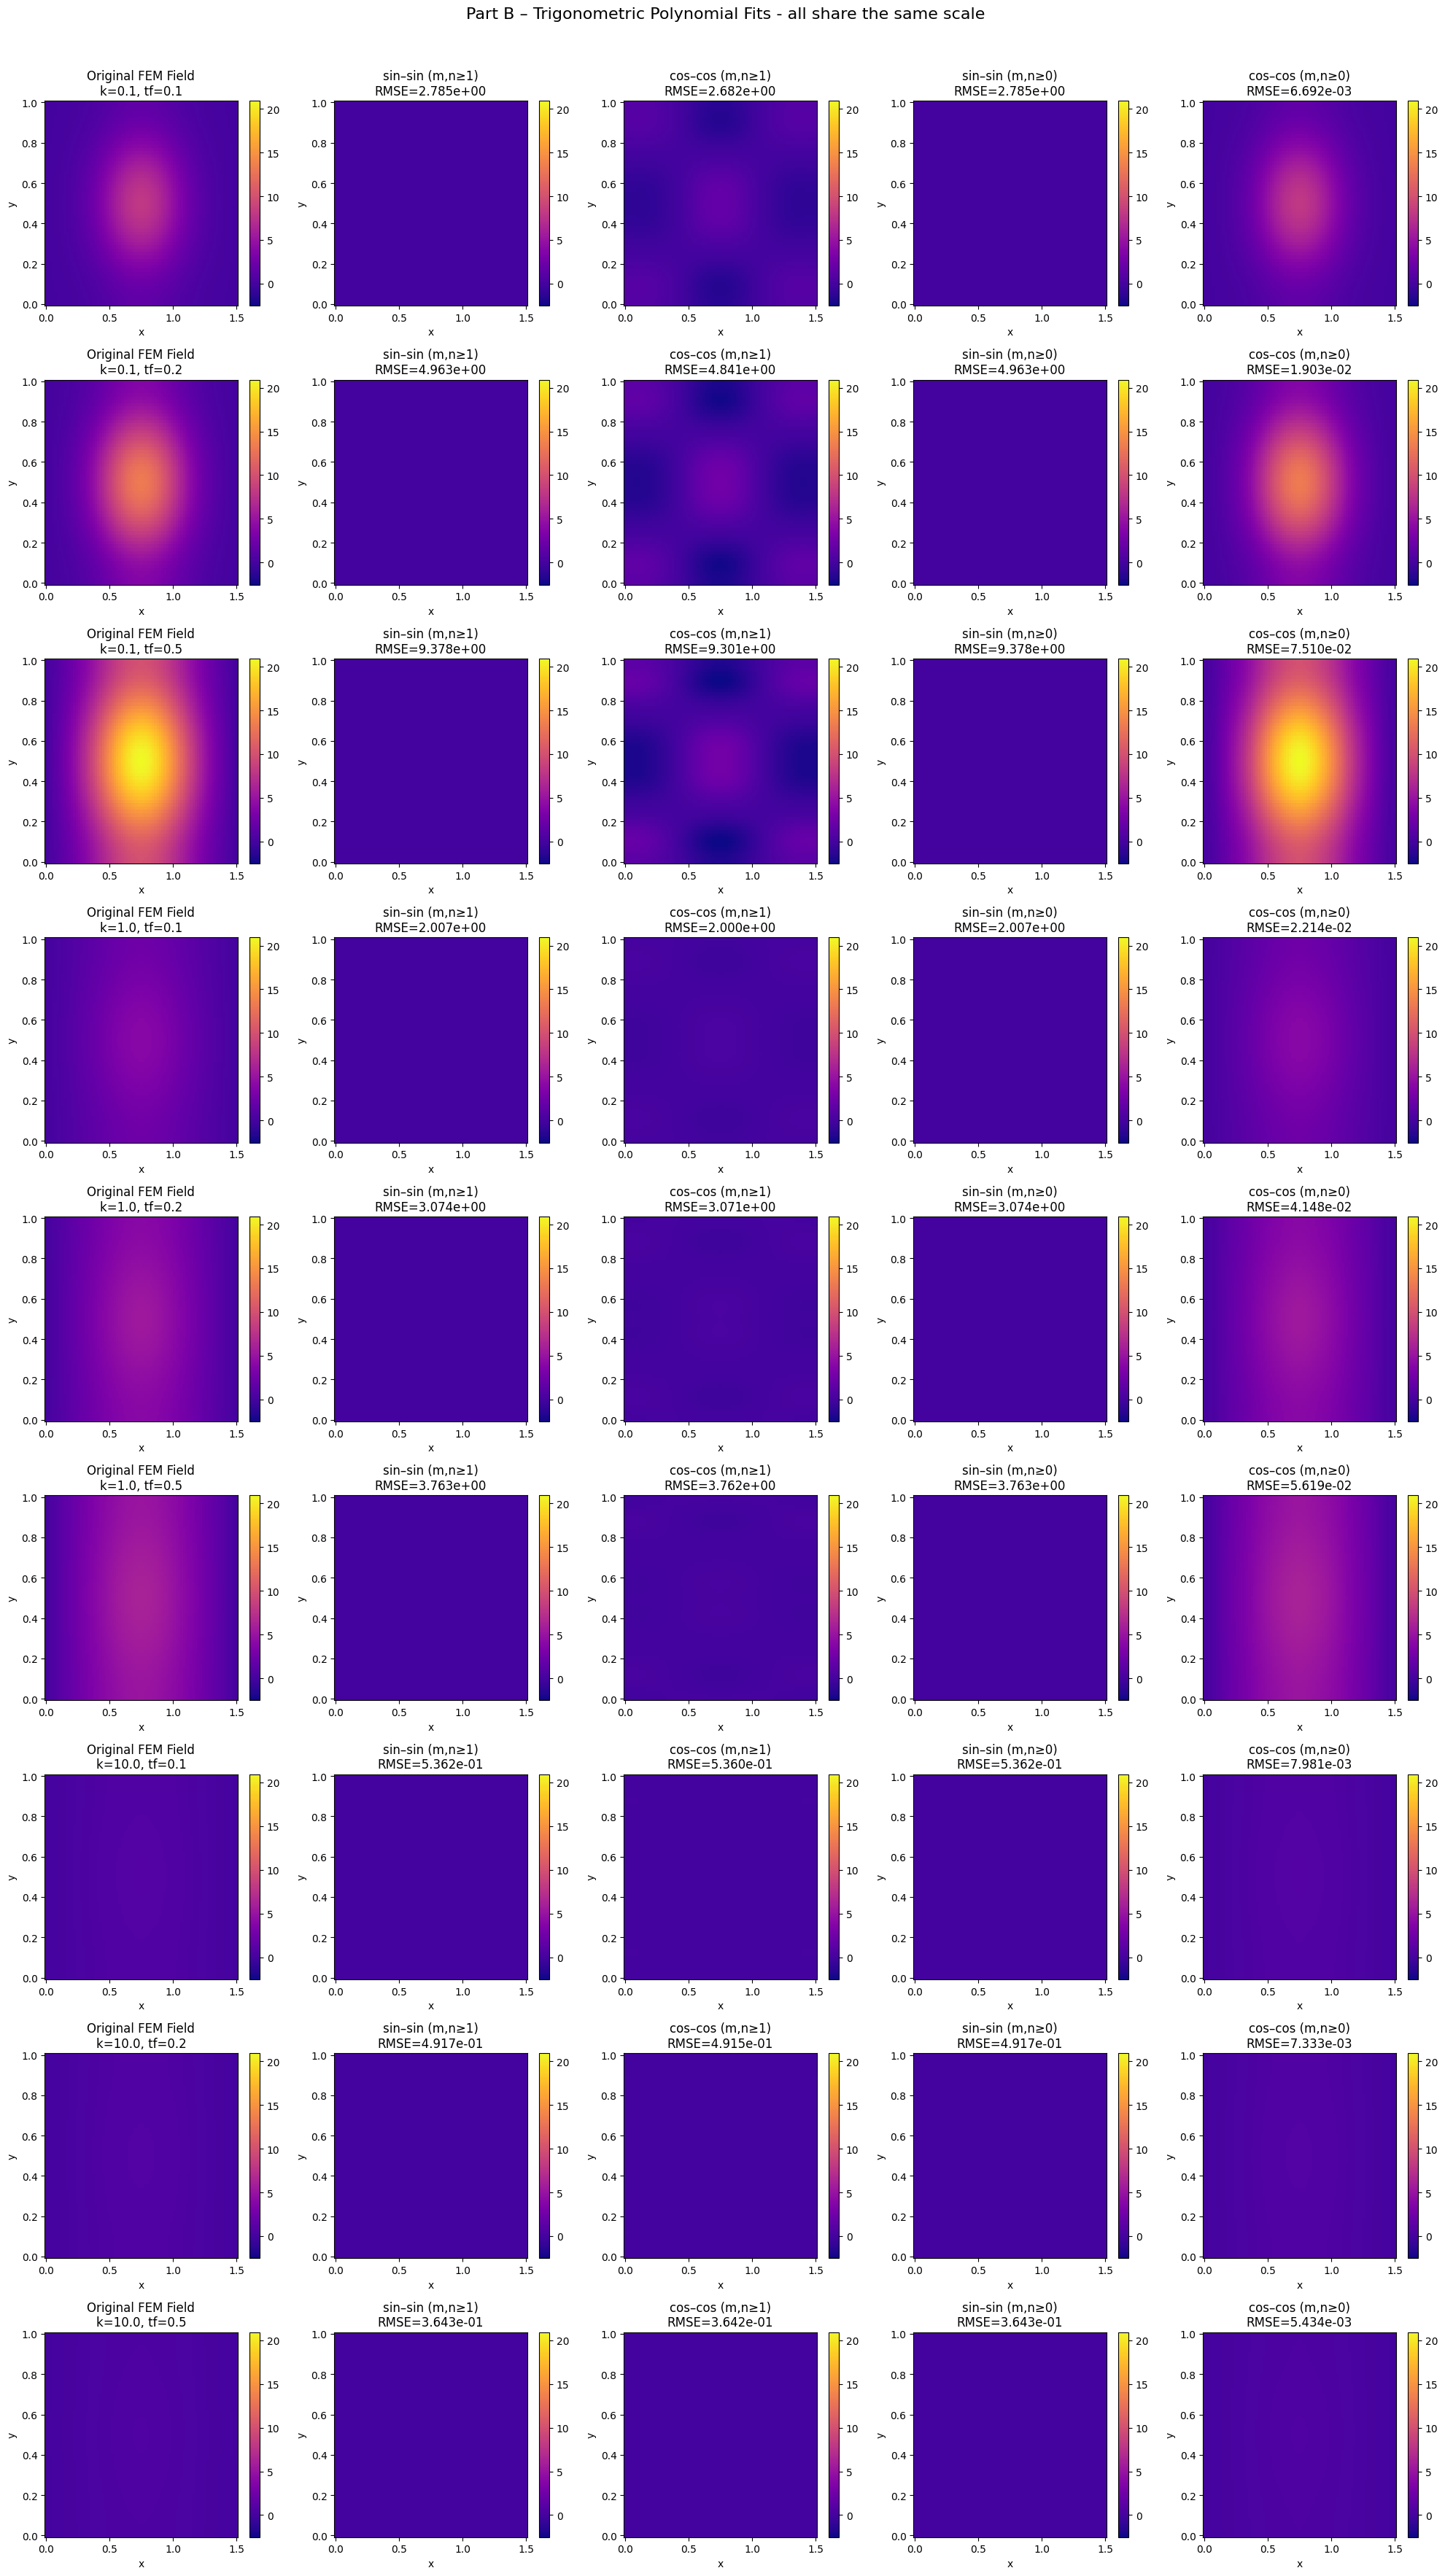

In [68]:
# everything shares the same scale

import matplotlib.pyplot as plt
import numpy as np

# Compute global vmin and vmax across all datasets
all_values = []
for (k_val, tf_val), (x, y, T, _) in result_dict.items():
    coeffs_sin11, _, Tfit_sin11 = fit_trig_surface(x, y, T, m_start=1, n_start=1, trig='sin', plot=False)
    coeffs_cos11, _, Tfit_cos11 = fit_trig_surface(x, y, T, m_start=1, n_start=1, trig='cos', plot=False)
    coeffs_sin00, _, Tfit_sin00 = fit_trig_surface(x, y, T, m_start=0, n_start=0, trig='sin', plot=False)
    coeffs_cos00, _, Tfit_cos00 = fit_trig_surface(x, y, T, m_start=0, n_start=0, trig='cos', plot=False)
    all_values.append(T)
    all_values.append(Tfit_sin11)
    all_values.append(Tfit_cos11)
    all_values.append(Tfit_sin00)
    all_values.append(Tfit_cos00)

global_min = np.min([np.min(f) for f in all_values])
global_max = np.max([np.max(f) for f in all_values])
print(f"Using global color scale: vmin={global_min:.3f}, vmax={global_max:.3f}")

# Plot all fields with unified color limits
fig, axes = plt.subplots(9, 5, figsize=(20, 36))
fig.suptitle("Part B – Trigonometric Polynomial Fits - all share the same scale", fontsize=16)

i = 0

for (k_val, tf_val), (x, y, T, _) in result_dict.items():
    coeffs_sin11, rmse_sin11, Tfit_sin11 = fit_trig_surface(x, y, T, m_start=1, n_start=1, trig='sin', plot=False)
    coeffs_cos11, rmse_cos11, Tfit_cos11 = fit_trig_surface(x, y, T, m_start=1, n_start=1, trig='cos', plot=False)
    coeffs_sin00, rmse_sin00, Tfit_sin00 = fit_trig_surface(x, y, T, m_start=0, n_start=0, trig='sin', plot=False)
    coeffs_cos00, rmse_cos00, Tfit_cos00 = fit_trig_surface(x, y, T, m_start=0, n_start=0, trig='cos', plot=False)

    X, Y = np.meshgrid(x, y)

    titles_top = [
        f"Original FEM Field\nk={k_val}, tf={tf_val}",
        "sin–sin (m,n≥1)",
        "cos–cos (m,n≥1)",
        "sin–sin (m,n≥0)",
        "cos–cos (m,n≥0)"
    ]
    fields_top = [T, Tfit_sin11, Tfit_cos11, Tfit_sin00, Tfit_cos00]
    rmses = [0, rmse_sin11, rmse_cos11, rmse_sin00, rmse_cos00]

    for j in range(5):
        pcm = axes[i, j].pcolormesh(
            X, Y, fields_top[j],
            shading='auto', cmap='plasma',
            vmin=global_min, vmax=global_max  # unified color scale
        )
        axes[i, j].set_title(
            f"{titles_top[j]}\nRMSE={rmses[j]:.3e}" if j > 0 else titles_top[j]
        )
        fig.colorbar(pcm, ax=axes[i, j])
        axes[i, j].set_xlabel("x")
        axes[i, j].set_ylabel("y")

    i += 1

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Per-column color scales:
  Column 1: vmin=0.000, vmax=20.881
  Column 2: vmin=-0.002, vmax=0.002
  Column 3: vmin=-2.529, vmax=2.678
  Column 4: vmin=-0.002, vmax=0.002
  Column 5: vmin=0.009, vmax=20.926


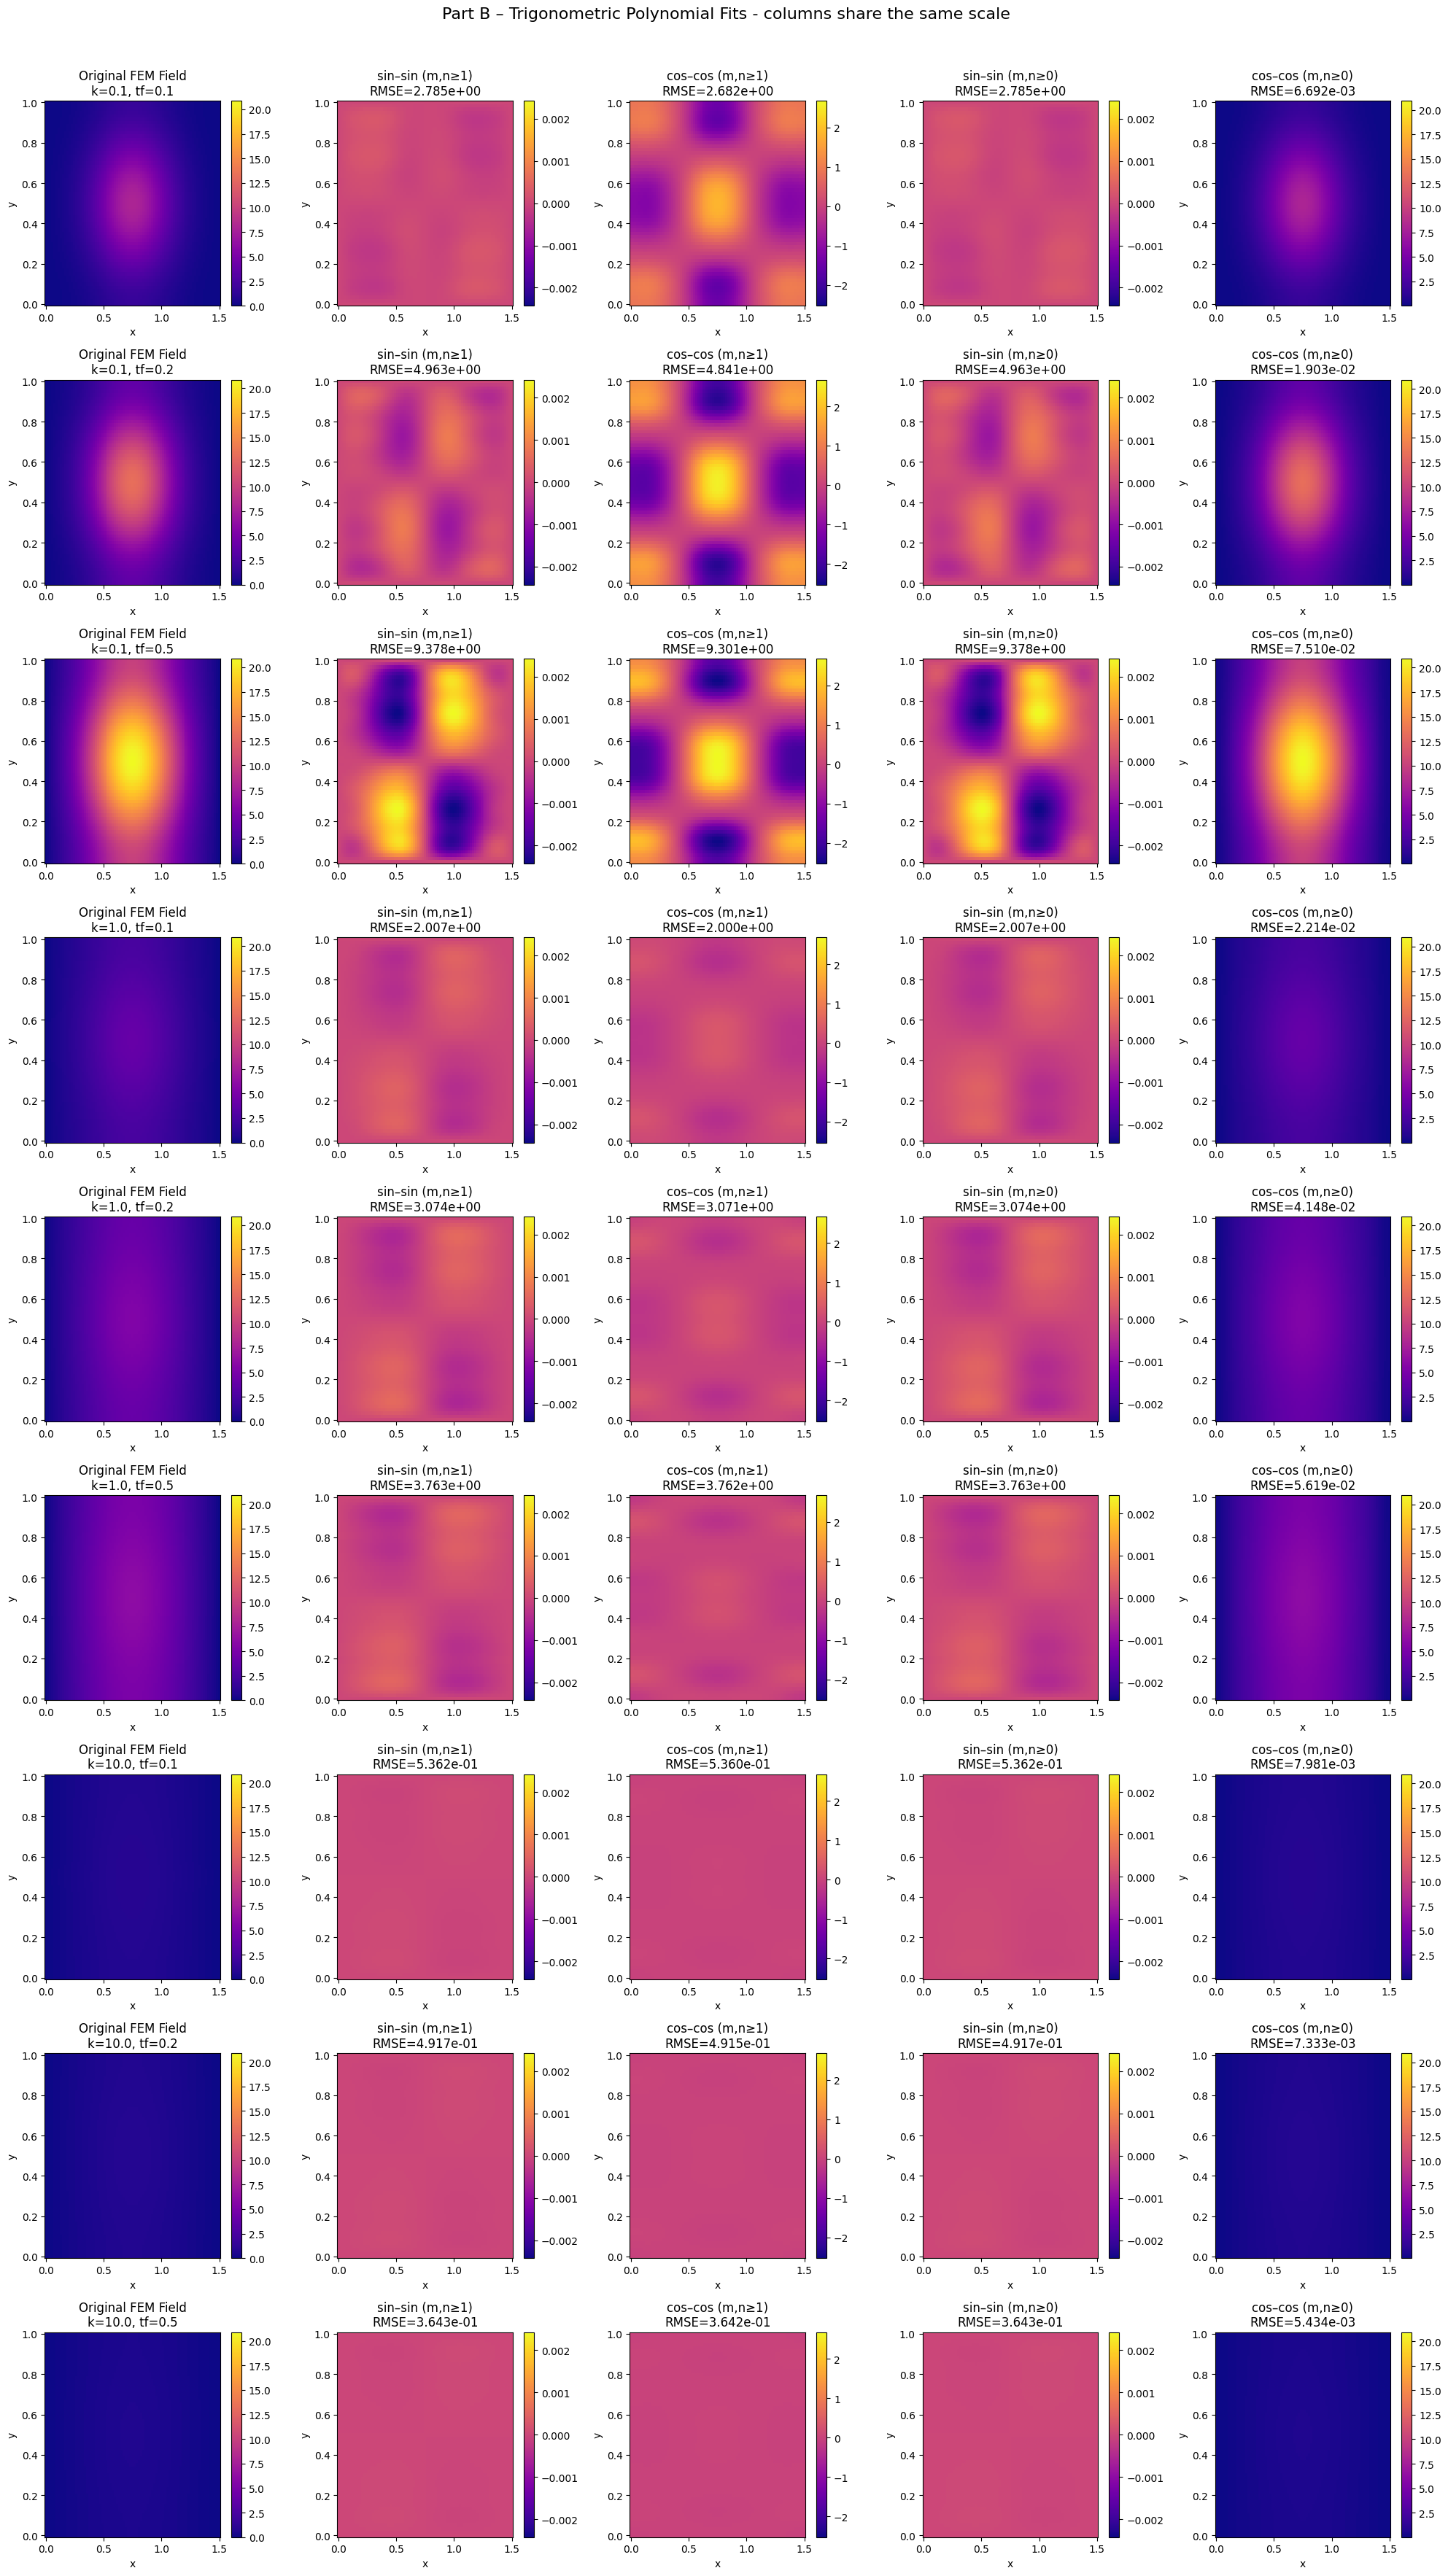

In [67]:
# columbs share the same scale 

import matplotlib.pyplot as plt
import numpy as np

# Compute vmin/vmax per column type (across all (k, tf))
col_values = [[] for _ in range(5)]

for (k_val, tf_val), (x, y, T, _) in result_dict.items():
    coeffs_sin11, _, Tfit_sin11 = fit_trig_surface(x, y, T, m_start=1, n_start=1, trig='sin', plot=False)
    coeffs_cos11, _, Tfit_cos11 = fit_trig_surface(x, y, T, m_start=1, n_start=1, trig='cos', plot=False)
    coeffs_sin00, _, Tfit_sin00 = fit_trig_surface(x, y, T, m_start=0, n_start=0, trig='sin', plot=False)
    coeffs_cos00, _, Tfit_cos00 = fit_trig_surface(x, y, T, m_start=0, n_start=0, trig='cos', plot=False)

    # Collect all five corresponding field types
    col_values[0].append(T)
    col_values[1].append(Tfit_sin11)
    col_values[2].append(Tfit_cos11)
    col_values[3].append(Tfit_sin00)
    col_values[4].append(Tfit_cos00)

# Compute vmin/vmax for each column
vmins = [np.min([np.min(f) for f in col]) for col in col_values]
vmaxs = [np.max([np.max(f) for f in col]) for col in col_values]
print("Per-column color scales:")
for j in range(5):
    print(f"  Column {j+1}: vmin={vmins[j]:.3f}, vmax={vmaxs[j]:.3f}")

# Plot all fields with per-column color limits
fig, axes = plt.subplots(9, 5, figsize=(20, 36))
fig.suptitle("Part B – Trigonometric Polynomial Fits - columns share the same scale", fontsize=16)

i = 0

for (k_val, tf_val), (x, y, T, _) in result_dict.items():
    coeffs_sin11, rmse_sin11, Tfit_sin11 = fit_trig_surface(x, y, T, m_start=1, n_start=1, trig='sin', plot=False)
    coeffs_cos11, rmse_cos11, Tfit_cos11 = fit_trig_surface(x, y, T, m_start=1, n_start=1, trig='cos', plot=False)
    coeffs_sin00, rmse_sin00, Tfit_sin00 = fit_trig_surface(x, y, T, m_start=0, n_start=0, trig='sin', plot=False)
    coeffs_cos00, rmse_cos00, Tfit_cos00 = fit_trig_surface(x, y, T, m_start=0, n_start=0, trig='cos', plot=False)

    X, Y = np.meshgrid(x, y)

    titles_top = [
        f"Original FEM Field\nk={k_val}, tf={tf_val}",
        "sin–sin (m,n≥1)",
        "cos–cos (m,n≥1)",
        "sin–sin (m,n≥0)",
        "cos–cos (m,n≥0)"
    ]
    fields_top = [T, Tfit_sin11, Tfit_cos11, Tfit_sin00, Tfit_cos00]
    rmses = [0, rmse_sin11, rmse_cos11, rmse_sin00, rmse_cos00]

    for j in range(5):
        pcm = axes[i, j].pcolormesh(
            X, Y, fields_top[j],
            shading='auto', cmap='plasma',
            vmin=vmins[j], vmax=vmaxs[j]  # consistent within column
        )
        axes[i, j].set_title(
            f"{titles_top[j]}\nRMSE={rmses[j]:.3e}" if j > 0 else titles_top[j]
        )
        fig.colorbar(pcm, ax=axes[i, j])
        axes[i, j].set_xlabel("x")
        axes[i, j].set_ylabel("y")

    i += 1

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


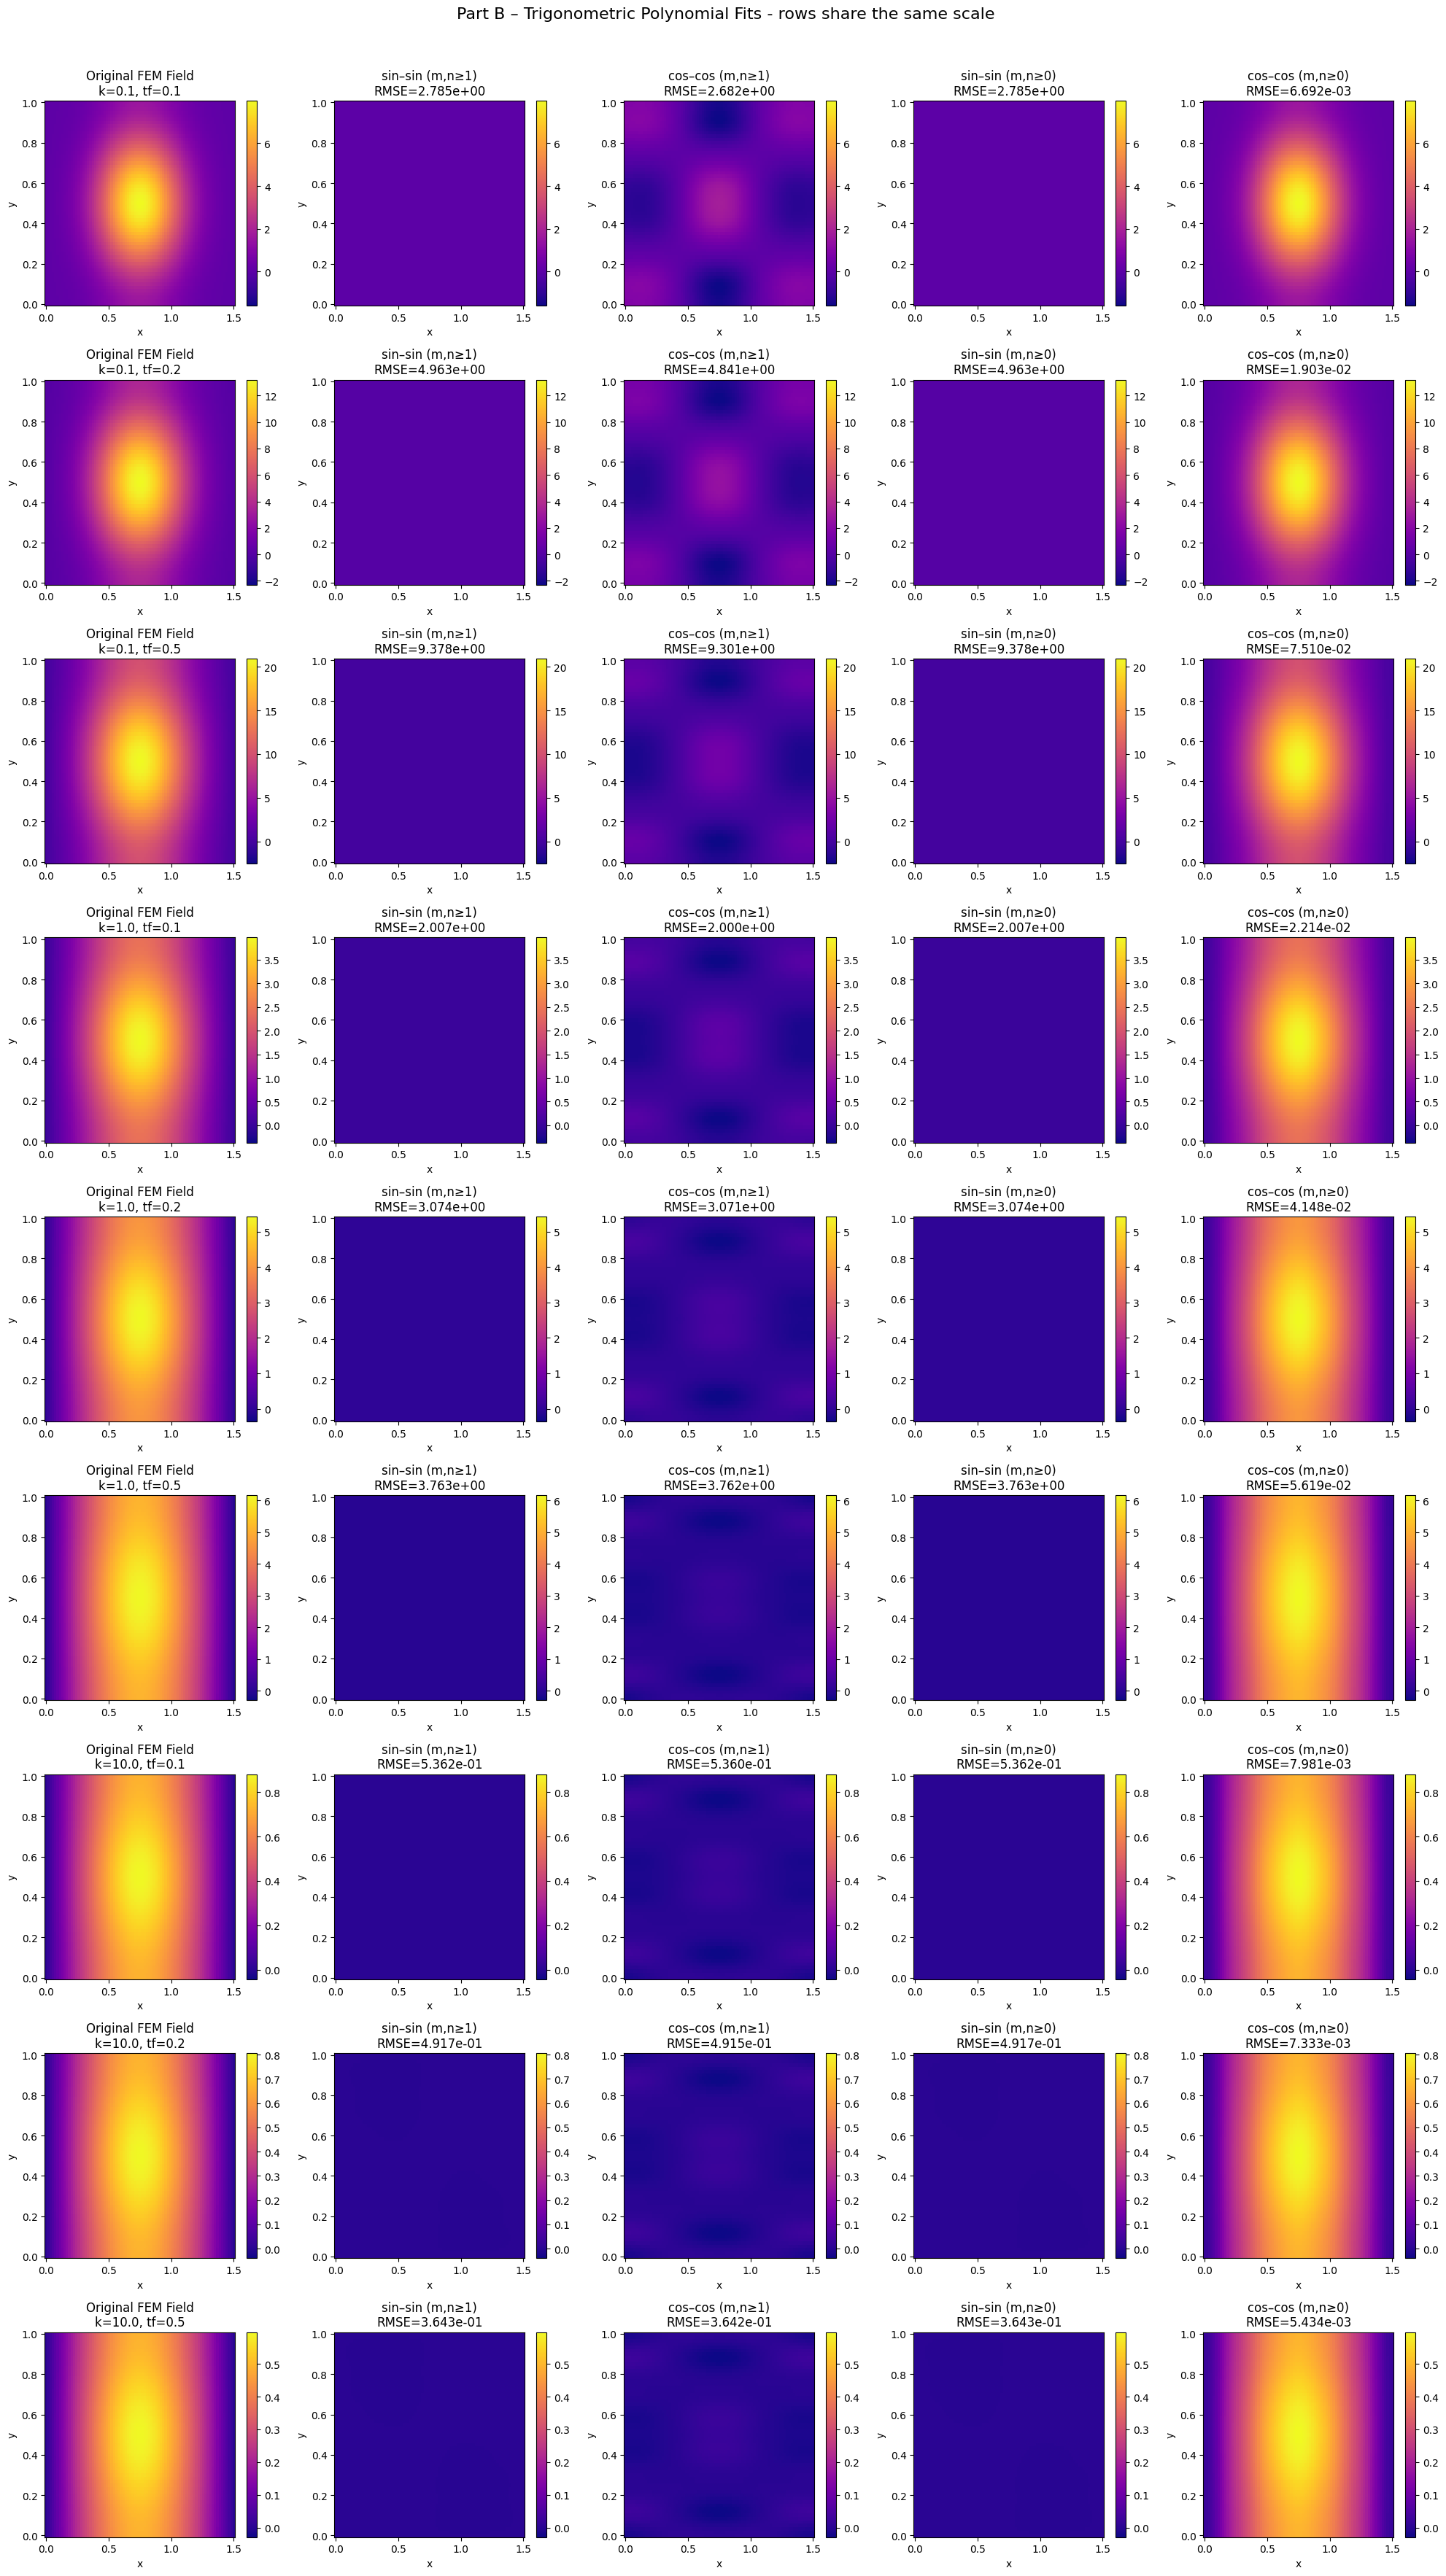

In [66]:
# rows share the same scale

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(9, 5, figsize=(20, 36))
fig.suptitle("Part B – Trigonometric Polynomial Fits - rows share the same scale", fontsize=16)

i = 0

for (k_val, tf_val), (x, y, T, _) in result_dict.items():
    # Run all four fits
    coeffs_sin11, rmse_sin11, Tfit_sin11 = fit_trig_surface(x, y, T, m_start=1, n_start=1, trig='sin', plot=False)
    coeffs_cos11, rmse_cos11, Tfit_cos11 = fit_trig_surface(x, y, T, m_start=1, n_start=1, trig='cos', plot=False)
    coeffs_sin00, rmse_sin00, Tfit_sin00 = fit_trig_surface(x, y, T, m_start=0, n_start=0, trig='sin', plot=False)
    coeffs_cos00, rmse_cos00, Tfit_cos00 = fit_trig_surface(x, y, T, m_start=0, n_start=0, trig='cos', plot=False)

    X, Y = np.meshgrid(x, y)

    # Collect all fields for this row
    titles_row = [
        f"Original FEM Field\nk={k_val}, tf={tf_val}",
        "sin–sin (m,n≥1)",
        "cos–cos (m,n≥1)",
        "sin–sin (m,n≥0)",
        "cos–cos (m,n≥0)"
    ]
    fields_row = [T, Tfit_sin11, Tfit_cos11, Tfit_sin00, Tfit_cos00]
    rmses = [0, rmse_sin11, rmse_cos11, rmse_sin00, rmse_cos00]

    # Compute shared color scale for this row 
    row_min = min(np.min(f) for f in fields_row)
    row_max = max(np.max(f) for f in fields_row)

    # Plot all 5 fields with same color limits
    for j in range(5):
        pcm = axes[i, j].pcolormesh(
            X, Y, fields_row[j],
            shading='auto', cmap='plasma',
            vmin=row_min, vmax=row_max  # shared within this row
        )
        axes[i, j].set_title(
            f"{titles_row[j]}\nRMSE={rmses[j]:.3e}" if j > 0 else titles_row[j]
        )
        fig.colorbar(pcm, ax=axes[i, j])
        axes[i, j].set_xlabel("x")
        axes[i, j].set_ylabel("y")

    i += 1  # move to next row

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# PART C
Please construct simple linear and non-linear regression models for T(t). 

# PART D
Sketch ideas for building space-time models for the “data” and try to build a model for the 10 points of data for which you have T(x,y,t) used in a). 